# Sound propagation simulator
_Copyright Anatole Hernot (Mines Paris), 2022. All rights reserved._

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

from physics.sound_propagation import *

# import matplotlib.colors as mcolors
# colors = list(mcolors.TABLEAU_COLORS.keys())

<br><br>

# 1. Oceanic metrics
## 1.1. Temperature profile

Temperate climate typical profile, manually extracted from an image & linearly extended to -10km.

https://archive.bigelow.org/shipmates/octemp.html

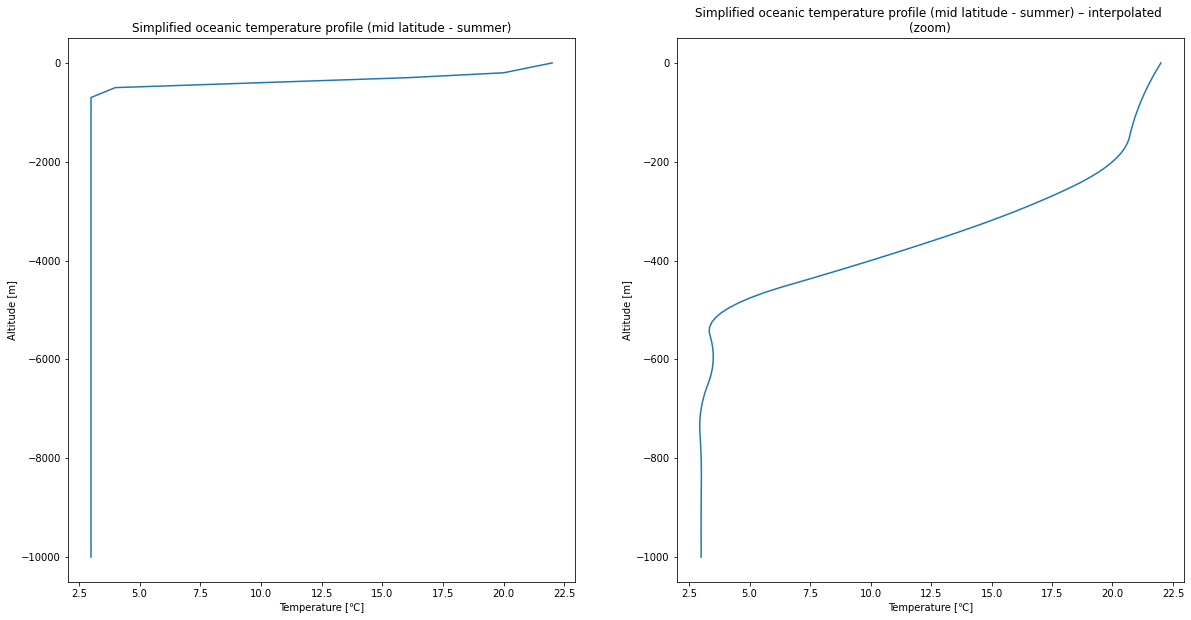

In [2]:
temperature_profile = np.array([
    [0, 22],
    [-100, 21],
    [-200, 20],
    [-300, 16],
    [-400, 10],
    [-500, 4],
    [-600, 3.5],
    [-700, 3],
    [-800, 3],
    [-900, 3],
    [-1000, 3],
    [-1100, 3],
    [-1200, 3],
    [-1300, 3],
    [-1400, 3],
    [-1500, 3],
    [-10000, 3]
])

temperature_profile = temperature_profile.T
calc_T = interpolate.interp1d(temperature_profile[0][::-1], temperature_profile[1][::-1], kind='quadratic')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(temperature_profile[1], temperature_profile[0])
axs[0].set_xlabel('Temperature [℃]')
axs[0].set_ylabel('Altitude [m]')
axs[0].set_title('Simplified oceanic temperature profile (mid latitude - summer)')

z = np.linspace(-1000, 0, 100)
axs[1].plot(calc_T(z), z)
axs[1].set_xlabel('Temperature [℃]')
axs[1].set_ylabel('Altitude [m]')
axs[1].set_title('Simplified oceanic temperature profile (mid latitude - summer) – interpolated \n(zoom)');

<br><br>

## 1.2. Salinity profile

Ocean salinity can be considered an invariant of depth in our calculations.

In [3]:
S = 35

<br><br>

## 1.3. $\mathrm{pH}$ profile

North atlantic (50°N, 41°W) typical profile, manually extracted from an image & linearly extended to -10km.

https://socratic.org/questions/how-does-ph-change-with-depth

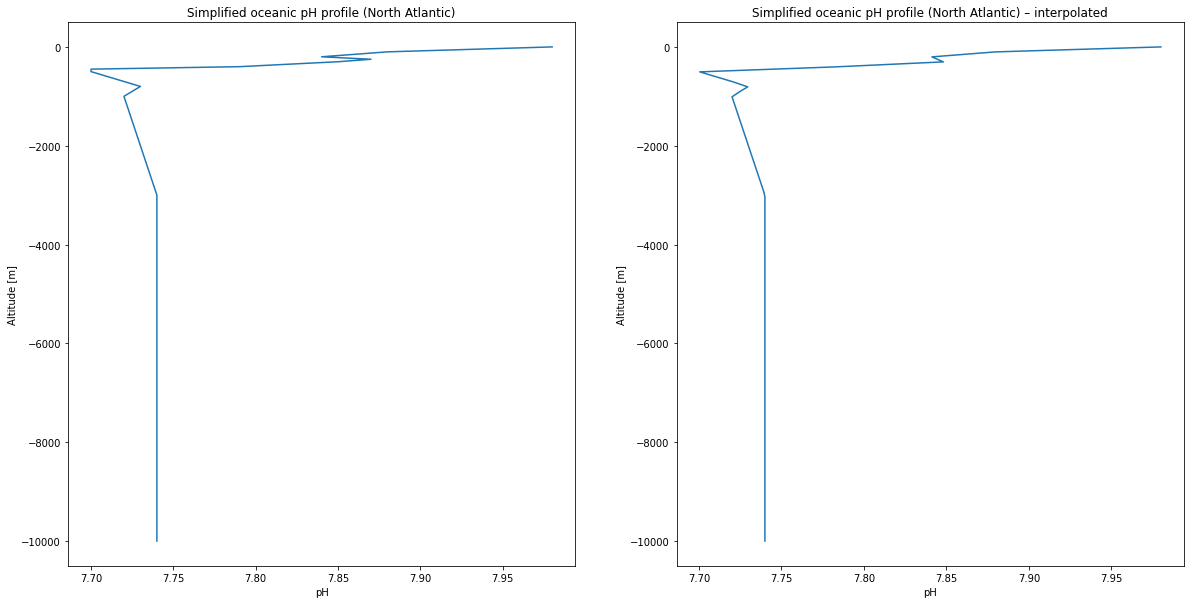

In [4]:
pH_profile = np.array([
    [0, 7.98],
    [-100, 7.88],
    [-200, 7.84],
    [-250, 7.87],
    [-300, 7.85],
    [-400, 7.79],
    [-450, 7.7],
    [-500, 7.7],
    [-600, 7.71],
    [-800, 7.73],
    [-1000, 7.72],
    [-2000, 7.73],
    [-3000, 7.74],
    [-10000, 7.74]
])

pH_profile = pH_profile.T
calc_pH = interpolate.interp1d(pH_profile[0][::-1], pH_profile[1][::-1], kind='linear')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(pH_profile[1], pH_profile[0])
axs[0].set_xlabel('pH')
axs[0].set_ylabel('Altitude [m]')
axs[0].set_title('Simplified oceanic pH profile (North Atlantic)')

z = np.linspace(-10000, 0, 100)
axs[1].plot(calc_pH(z), z)
axs[1].set_xlabel('pH')
axs[1].set_ylabel('Altitude [m]')
axs[1].set_title('Simplified oceanic pH profile (North Atlantic) – interpolated');

<br><br>

## 1.4. Sound velocity profile

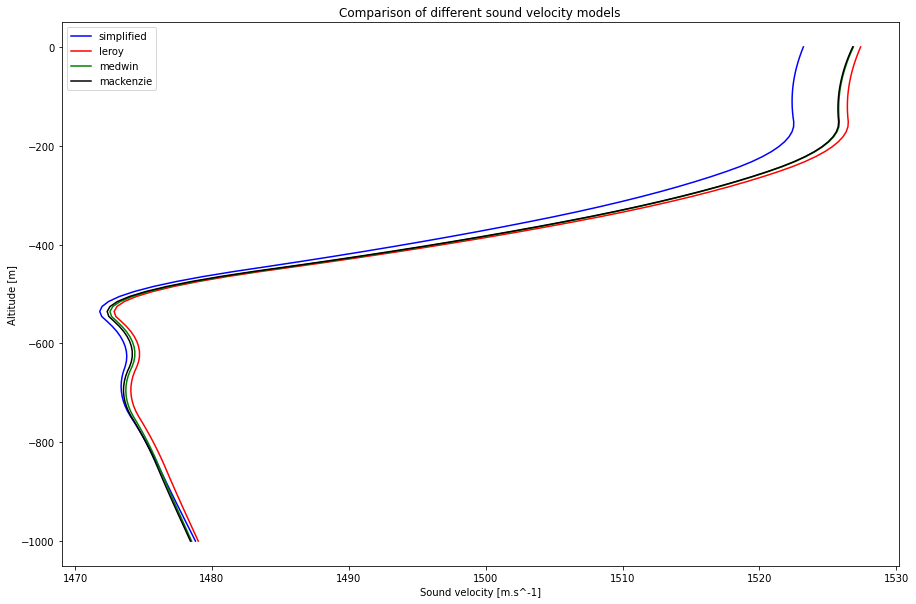

In [5]:
z = np.linspace(-1000, 0, 100)
T = calc_T(z)

c_simplified = sound_velocity_simplified(S, T, z)
c_leroy      = sound_velocity_leroy     (S, T, z)
c_medwin     = sound_velocity_medwin    (S, T, z)
c_mackenzie  = sound_velocity_mackenzie (S, T, z)


plt.figure(figsize=(15, 10))

plt.plot(c_simplified, z, c='blue', label='simplified')
plt.plot(c_leroy, z, c='red', label='leroy')
plt.plot(c_medwin, z, c='green', label='medwin')
plt.plot(c_mackenzie, z, c='black', label='mackenzie')

plt.legend()
plt.title('Comparison of different sound velocity models')
plt.xlabel('Sound velocity [m.s^-1]')
plt.ylabel('Altitude [m]')
plt.show()

<br><br>

## 1.5. Sound velocity gradient profile

We will retain Medwin's sound velocity calculation method.

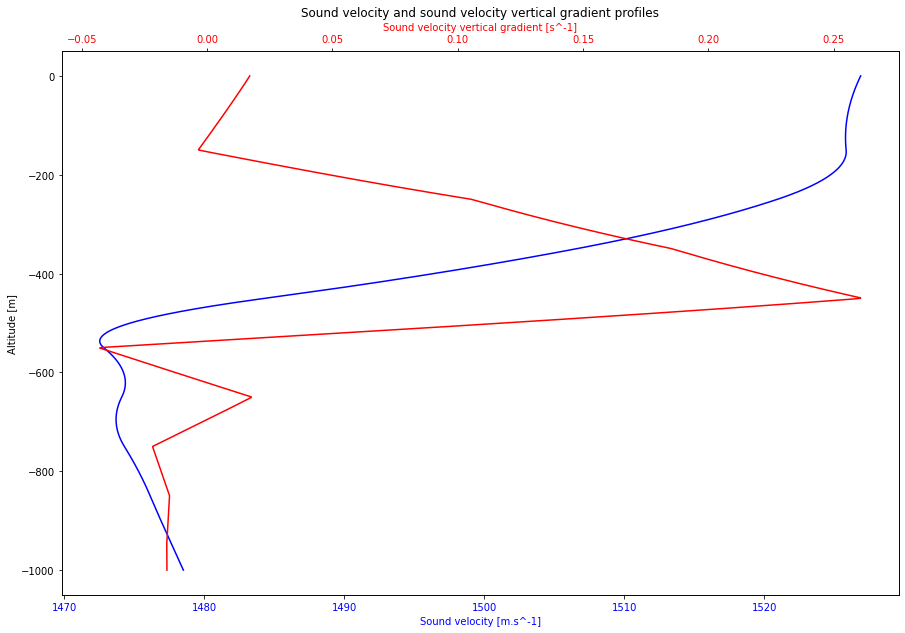

In [6]:
def calc_c (z):
    """
    Salinity-invariant sound velocity
    :param z: Altitude (in m)
    :return: Sound velocity (in m.s^-1)
    """
    return sound_velocity_medwin(S, calc_T(z), z)

# Calculate sound velocity gradient
z = np.linspace(-10000, 0, 10000)
c = calc_c(z)
dz_c = np.gradient(c)

# Interpolate sound velocity gradient into a function
calc_dz_c = interpolate.interp1d(z, dz_c, kind='quadratic')



z_fine = np.linspace(-1000, 0, 10000)
fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.set_title('Sound velocity and sound velocity vertical gradient profiles')

ax1.plot(calc_c(z_fine), z_fine, c='blue')
ax1.set_xlabel('Sound velocity [m.s^-1]', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')
ax1.set_ylabel('Altitude [m]')

ax2 = ax1.twiny()
ax2.plot(calc_dz_c(z_fine), z_fine, c='red')
ax2.set_xlabel('Sound velocity vertical gradient [s^-1]', color='red')
ax2.tick_params(axis='x', labelcolor='red')

<br><br>

## 1.6. Sound absorption profile

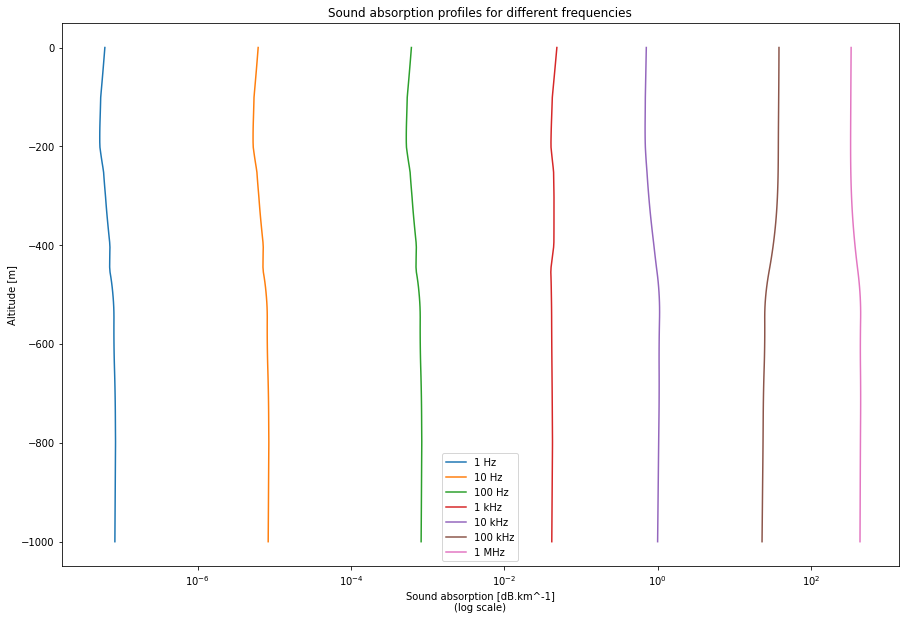

In [30]:
from absorption import calc_absorption

z = np.linspace(-1000, 0, 100)
T = calc_T(z)

plt.figure(figsize=(15, 10))

freqs = {1:'1 Hz', 10:'10 Hz', 100:'100 Hz', 1000:'1 kHz', 10000:'10 kHz', 100000:'100 kHz', 1000000:'1 MHz'}
for f in freqs.keys():
    A = calc_absorption(f, z, T, S, calc_pH(z))
    plt.semilogx(A, z, label=freqs[f])

plt.legend()
plt.title('Sound absorption profiles for different frequencies')
plt.xlabel('Sound absorption [dB.km^-1]\n(log scale)')
plt.ylabel('Altitude [m]')
plt.show()

<br><br>

# 2. Simulation
## 2.0. Ocean floor profile

Test profile (invented).

In [8]:
ground_profile = np.array([
    [0, -1000],
    [500, -1500],
    [1000, -1250],
    [1500, -2000],
    [2000, -3000],
    [2100, -5000],
    [2150, -2400],
    [2500, -2300],
    [3000, -3310],
    [5000, -4000],
    [5030, -2400],
    [5080, -2430],
    [6012, -3200],
    [10000, -3100],
    [20000, -2893],
    [40000, -2450],
    [80000, -2638],
    [200000, -2500]
])

ground_profile = ground_profile.T
calc_ground_z = interpolate.interp1d(ground_profile[0], ground_profile[1], kind='linear')
# calc_ground_z = interpolate.interp1d(ground_profile[0], ground_profile[1], kind='quadratic')

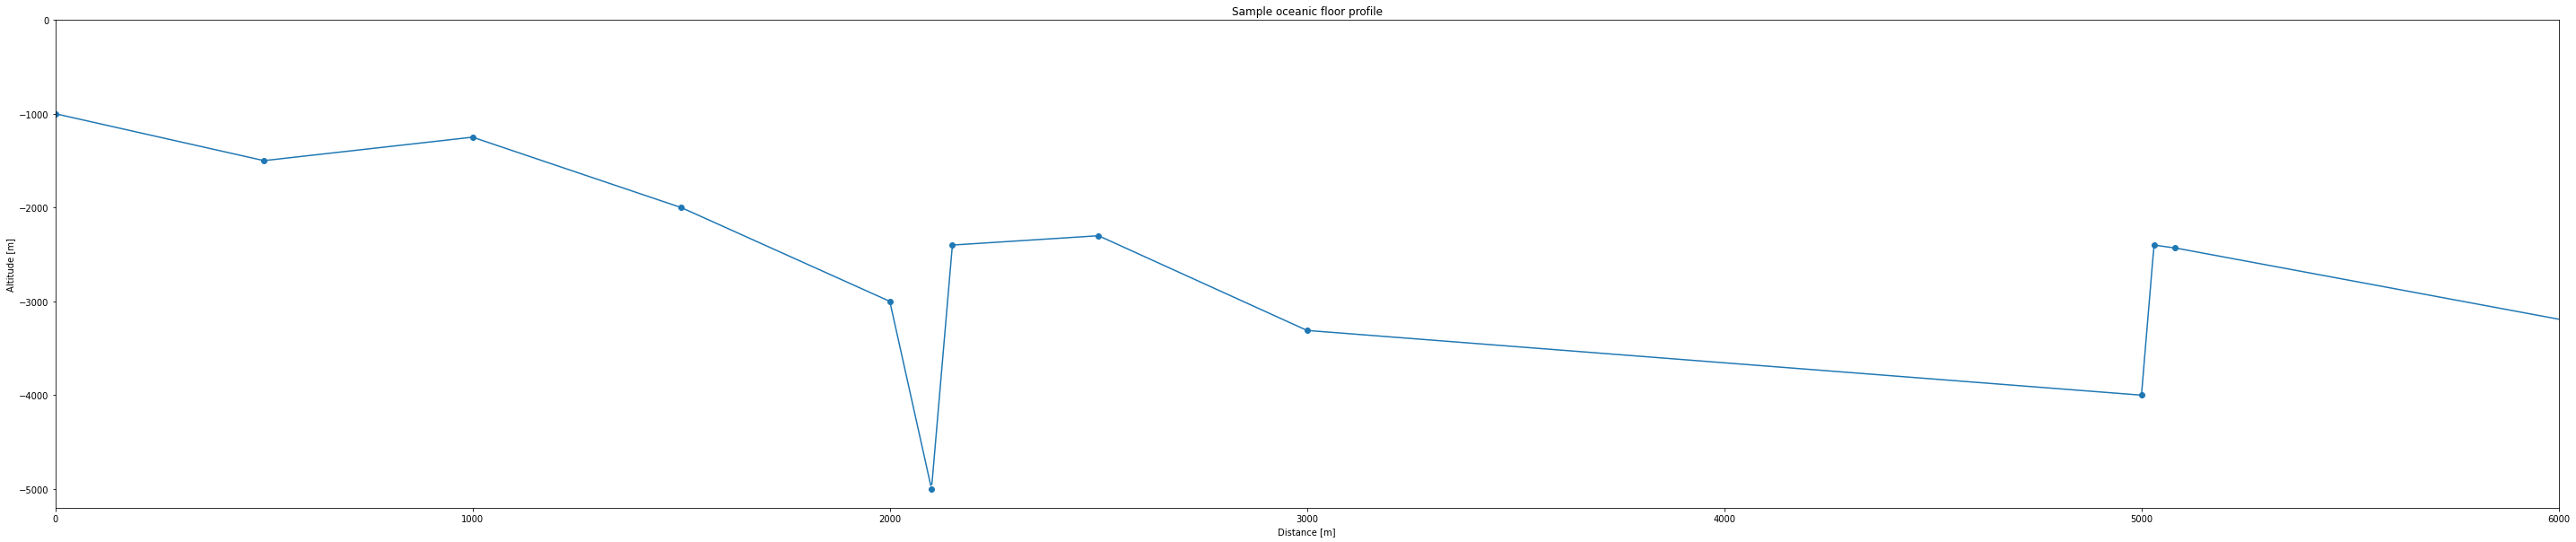

In [9]:
plt.figure(figsize=(50, 10))

x = np.linspace(0, 6000, 2000)
plt.plot(x, calc_ground_z(x))
plt.scatter(ground_profile[0], ground_profile[1])

plt.ylim(top=0)
plt.xlim((x[0], x[-1]))

plt.xlabel('Distance [m]')
plt.ylabel('Altitude [m]')
plt.title('Sample oceanic floor profile')
plt.show()

<br><br>

## 2.1. Raytracing

In [26]:
from scipy.optimize import fsolve
from scipy.misc import derivative

# TODO: cleanup parameters (limits set defaults, allow val and func, default n_steps and step_z)
#       => actually allow only points or arrays, no functions => better derivative calculation (linear interpolation)
# TODO: allow for propagation backwards
# TODO: calculate derivative using finite differentiation

def sound_curve (n_steps, step_z, x0, z0, theta_0, limit_top_val, limit_bottom_func):
    """
    Propagate a sound ray in seawater
    :param n_steps: Number of simulation steps
    :param step_z: Vertical step size (in m)
    :param x0: Initial x-axis position (relative to the ocean floor profile)
    :param z0: Initial z-axis position
    :param theta_0: Initial propagation angle (from the vertical)
    :param limit_top_val: Top limit
    :param limit_bottom_func: Bottom limit function
    :return: X and Z arrays of the sound ray's path
    """
    
    # Initialise differential solver parameters
    c0      = calc_c(0)
    mult   = -1 * np.power(c0 / np.sin(theta_0), 2)  # differential equation multiplier
    X = np.array([x0, ])
    Z = np.array([z0, ])
    dx_z   = 1 / np.tan(theta_0)
    dxdx_z = 0  # no initial curvature


    for i in range(n_steps):
        x = X[i]
        z = Z[i]

        # Calculate point
        dz = np.sign(dx_z) * step_z
        dx = dz / dx_z

        x_new = x + dx
        z_new = z + dz
        if z_new > limit_top_val:
            z_new = limit_top_val
            x_new = x + (limit_top_val - z) / dx_z
            dx_z *= -1

        elif z_new < limit_bottom_func(x_new):
            # Calculate intersection
            def g(x1): return limit_bottom_func(x) - dx_z * (x1 - x) - z
            x_new = float(fsolve(g, x0=x))
            z_new = limit_bottom_func(x_new)

            # Calculate reflection direction
            dx_z_ground = derivative(limit_bottom_func, x_new, dx=x_new-x)
            # dx_z_ground = (z_new - limit_bottom_func(z)) / (x_new - x)

            alpha_new = np.pi - np.arctan(dx_z) - 2 * np.arctan(dx_z_ground)
            dx_z = np.tan(alpha_new)
            
        if x_new < x: break  # prevent backwards reflection (to change)

        X = np.concatenate((X, np.array([x_new, ])), axis=0)
        Z = np.concatenate((Z, np.array([z_new, ])), axis=0)

        # Calculate new point's properties
        c = calc_c(z)
        g = calc_dz_c(z)

        dxdx_z = mult * g / np.power(c, 3)
        dx_z  += dxdx_z * dx

    return np.array(X), np.array(Z)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/misc/common.py:145: RuntimeWarning: invalid value encountered in double_scalars
  return val / prod((dx,)*n,axis=0)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/misc/common.py:145: RuntimeWarning: invalid value encountered in double_scalars
  return val / prod((dx,)*n,axis=0)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/misc/common.py:145: RuntimeWarning: invalid value encountered in double_scalars
  return val / prod((dx,)*n,axis=0)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/misc/common.py:145: RuntimeWarning: invalid value encountered in double_scalars
  return val / prod((dx,)*n,axis=0)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/misc/common.py:145: RuntimeWarning: invalid value encountered in double_scalars
  return val / prod((dx,)*n,axis=0)


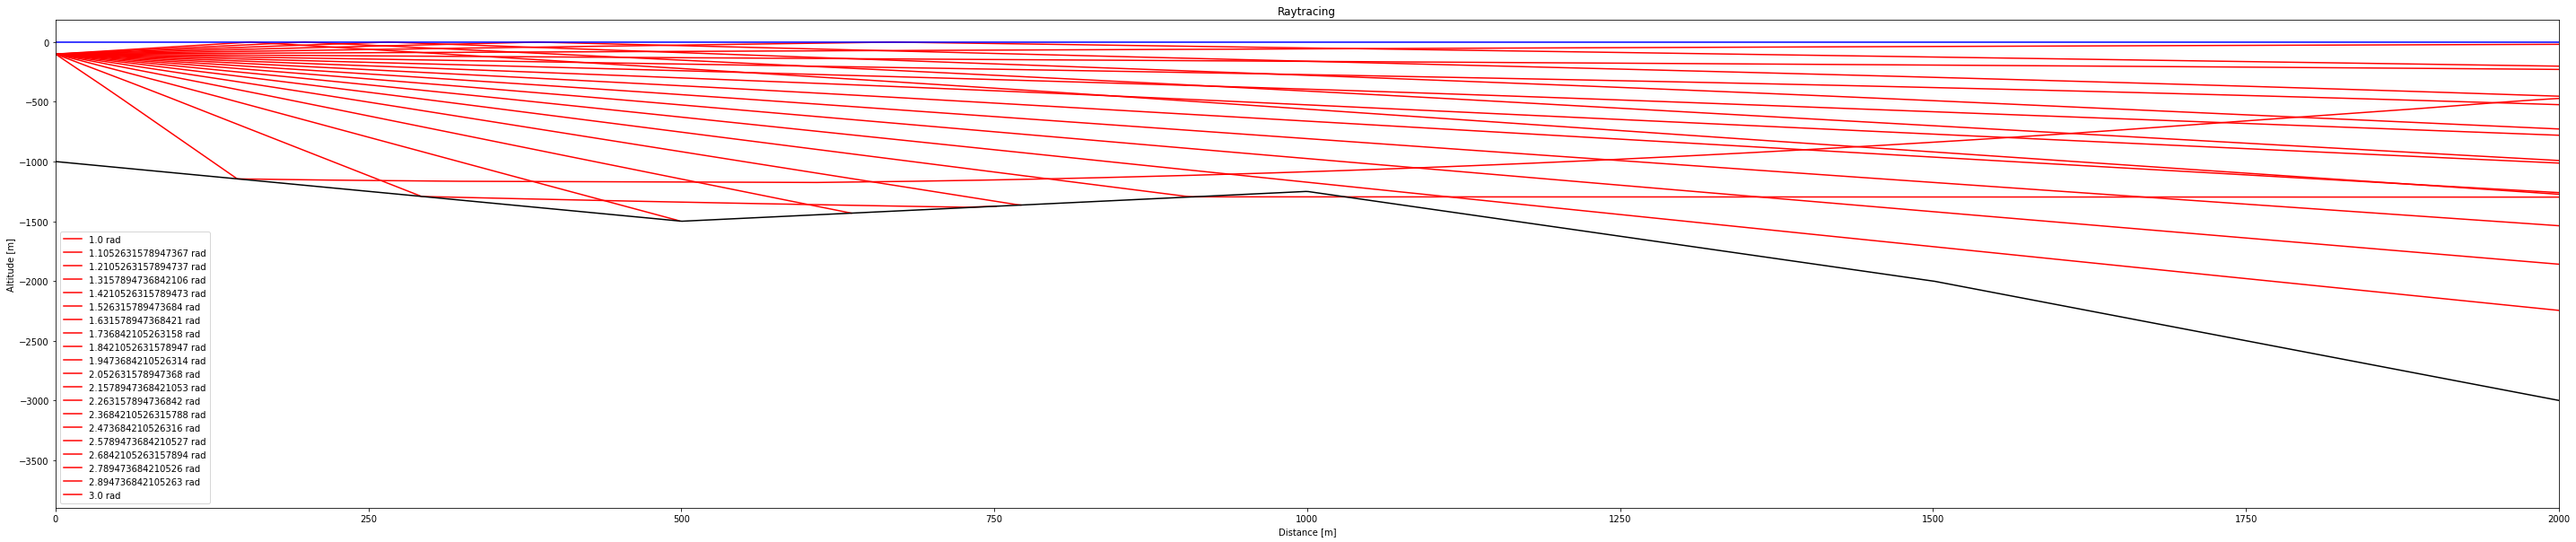

In [27]:
LIMIT_TOP = 0  # in m
LIMIT_BOTTOM = calc_ground_z

n_steps = 1000
step_z = 10

# Initial conditions
x0      = 0
z0      = -100
theta_0 = 3.14/2 -0.1  #in radians



plt.figure(figsize=(50, 10))

thetas = np.linspace(1, 3, 20)  #np.linspace(0.2, 3, 5)
for theta_0 in thetas:
    X, Z = sound_curve(n_steps, step_z, x0, z0, theta_0, LIMIT_TOP, LIMIT_BOTTOM)
    plt.plot(X, Z, c='red', label=f'{theta_0} rad')



x_lim = (0, 2000)
plt.plot(x_lim, (0, 0), c='blue')
x_linspace = np.linspace(x_lim[0], x_lim[1], 1000)
plt.plot(x_linspace, LIMIT_BOTTOM(x_linspace), c='black')
plt.xlim(x_lim)

plt.title('Raytracing')
plt.xlabel('Distance [m]')
plt.ylabel('Altitude [m]')
plt.legend()
plt.show()

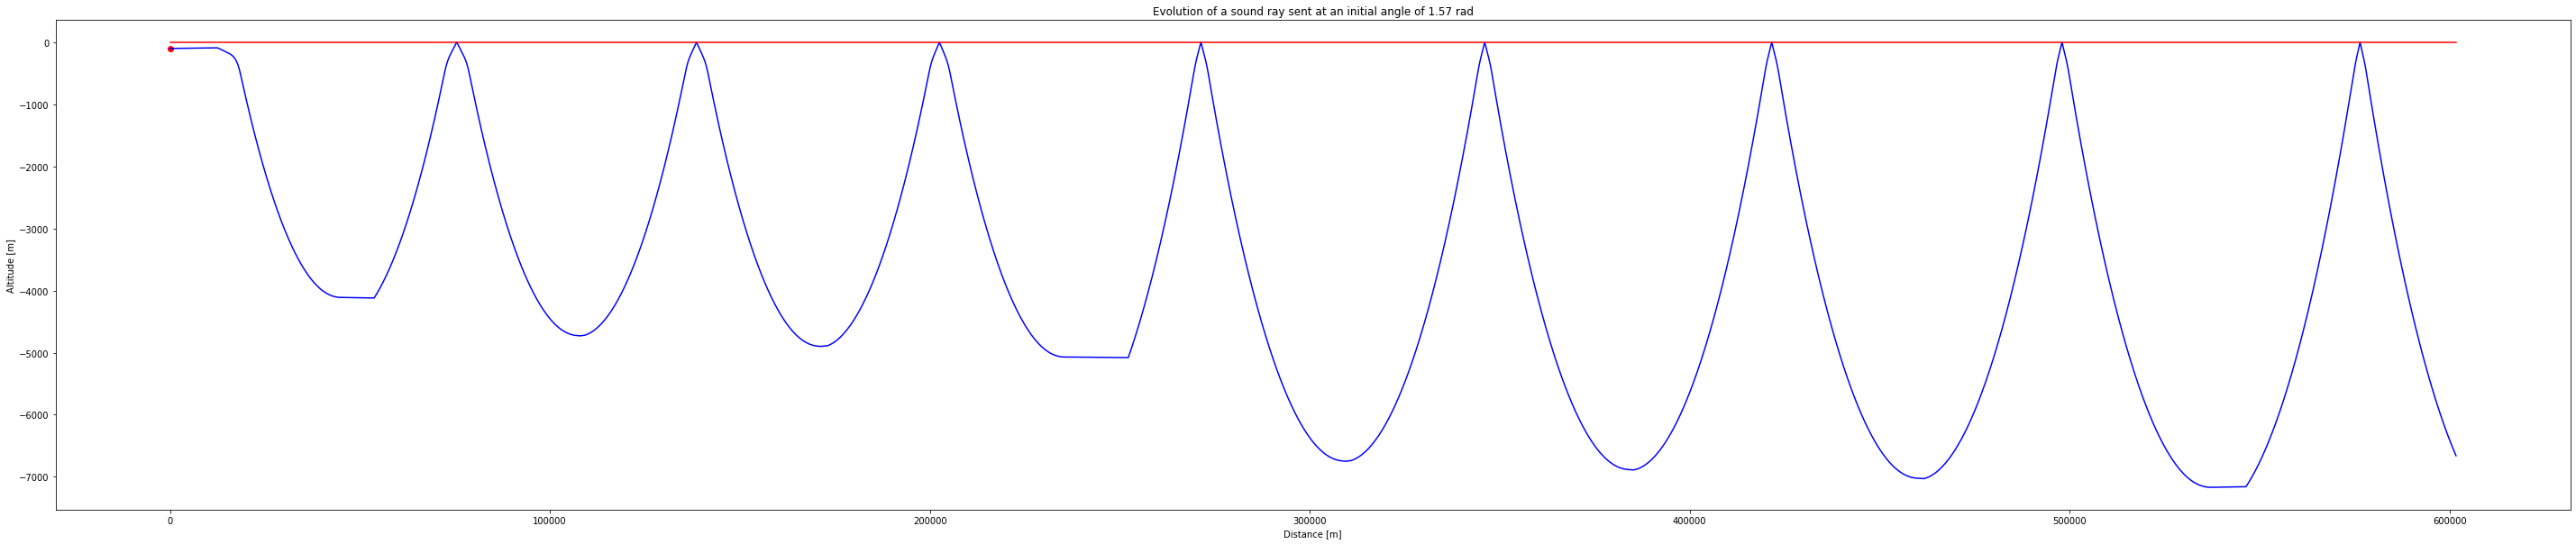

In [24]:
def LIMIT_BOTTOM(x): return np.ones_like(x) * -100000


n_steps = 10000
step_z = 10
x0 = 0
z0 = -100
theta_0 = 3.14/2
X, Z = sound_curve(n_steps, step_z, x0, z0, theta_0, LIMIT_TOP, LIMIT_BOTTOM)

plt.figure(figsize=(50, 10))
plt.plot(X, Z, c='blue')
plt.scatter(x0, z0, c='red')
plt.plot((X[0], X[-1]), (0, 0), c='red')
# plt.plot(X, LIMIT_BOTTOM(X), c='red')
plt.title(f'Evolution of a sound ray sent at an initial angle of {theta_0} rad')
plt.xlabel('Distance [m]')
plt.ylabel('Altitude [m]')
plt.show()

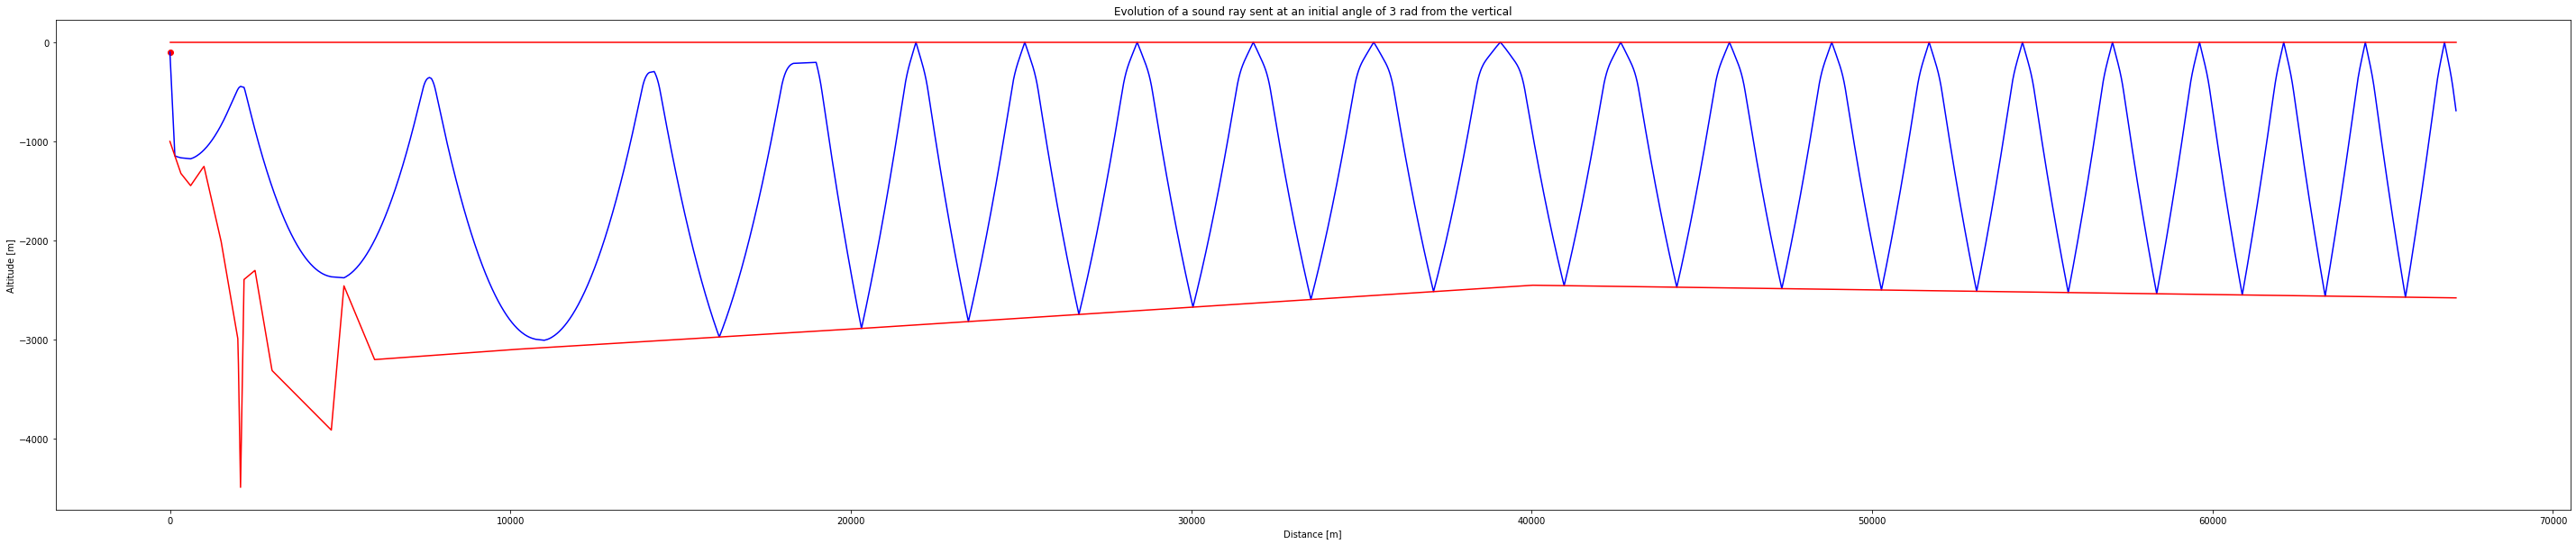

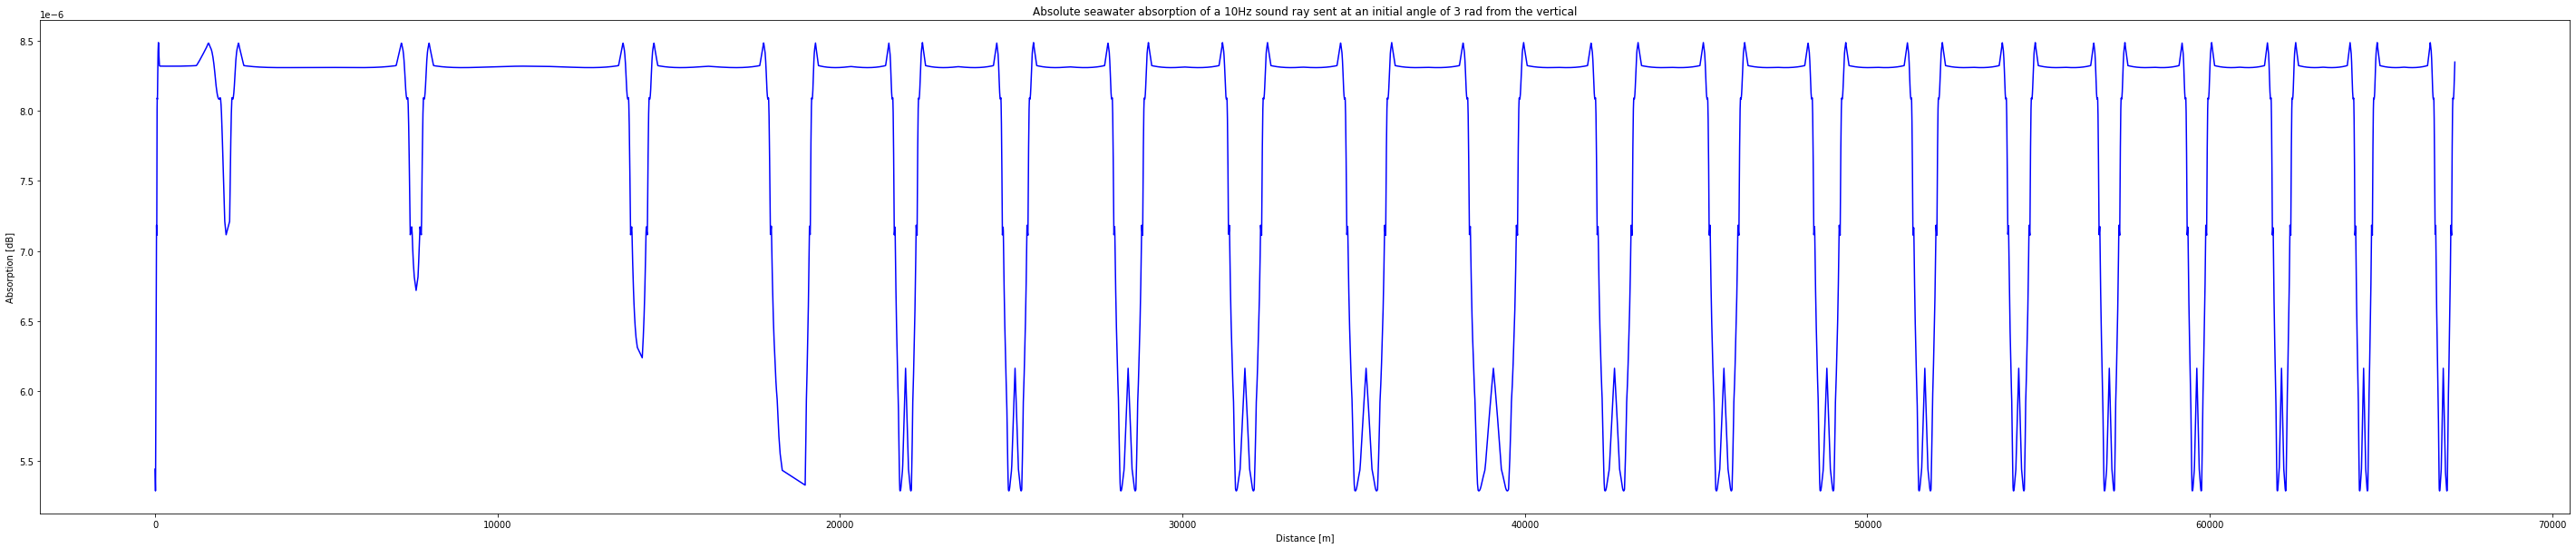

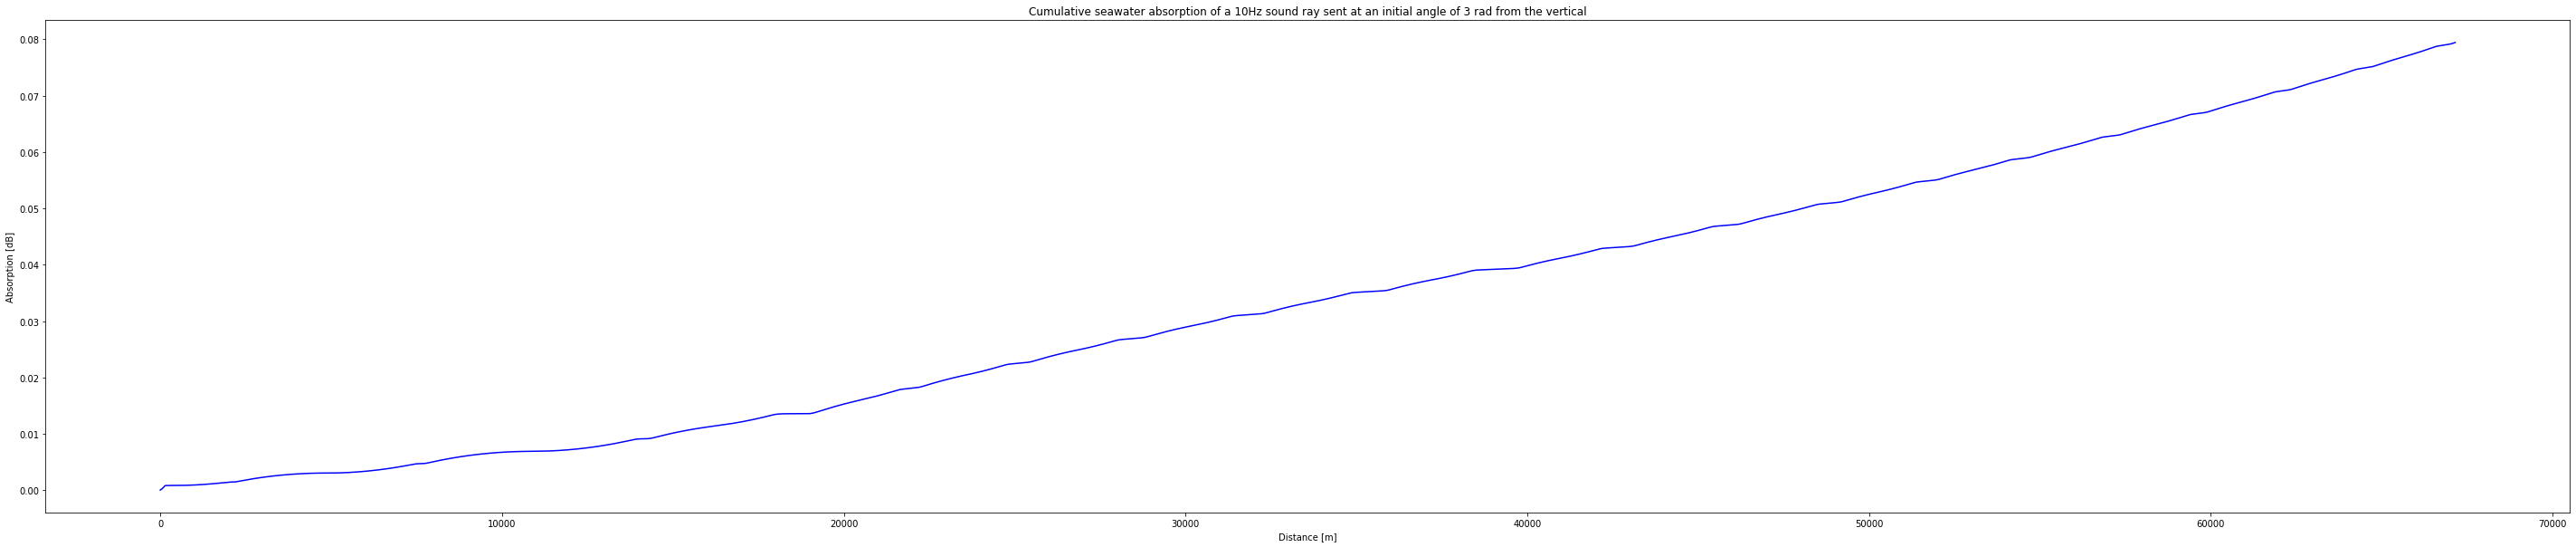

In [25]:
LIMIT_BOTTOM = calc_ground_z
n_steps = 10000
step_z = 10
x0 = 0
z0 = -100
theta_0 = 3
X, Z = sound_curve(n_steps, step_z, x0, z0, theta_0, LIMIT_TOP, LIMIT_BOTTOM)

f = 10  # Hz
A = calc_absorption(f, Z, calc_T(Z), S, calc_pH(Z))


plt.figure(figsize=(50, 10))
plt.plot(X, Z, c='blue')
plt.scatter(x0, z0, c='red')
plt.plot((X[0], X[-1]), (0, 0), c='red')
plt.plot(X, LIMIT_BOTTOM(X), c='red')
plt.title(f'Evolution of a sound ray sent at an initial angle of {theta_0} rad from the vertical')
plt.xlabel('Distance [m]')
plt.ylabel('Altitude [m]')
plt.show()

plt.figure(figsize=(50, 10))
plt.plot(X, A, c='blue')
plt.title(f'Absolute seawater absorption of a {f}Hz sound ray sent at an initial angle of {theta_0} rad from the vertical')
plt.xlabel('Distance [m]')
plt.ylabel('Absorption [dB]')
plt.show()


A_cum = np.cumsum(A)
plt.figure(figsize=(50, 10))
plt.plot(X, A_cum, c='blue')
plt.title(f'Cumulative seawater absorption of a {f}Hz sound ray sent at an initial angle of {theta_0} rad from the vertical')
plt.xlabel('Distance [m]')
plt.ylabel('Absorption [dB]')
plt.show()


In [33]:
def sound_curve_absorption (f, n_steps, step_z, x0, z0, theta_0, limit_top_val, limit_bottom_func):
    """
    Propagate a sound ray in seawater
    :param n_steps: Number of simulation steps
    :param step_z: Vertical step size (in m)
    :param x0: Initial x-axis position (relative to the ocean floor profile)
    :param z0: Initial z-axis position
    :param theta_0: Initial propagation angle (from the vertical)
    :param limit_top_val: Top limit
    :param limit_bottom_func: Bottom limit function
    :return: X and Z arrays of the sound ray's path
    """
    # Initialise differential solver parameters
    c0      = calc_c(0)
    mult   = -1 * np.power(c0 / np.sin(theta_0), 2)  # differential equation multiplier
    X = np.array([x0, ])
    Z = np.array([z0, ])
    dx_z   = 1 / np.tan(theta_0)
    dxdx_z = 0  # no initial curvature

    a = 0.
    A = np.array([a, ]) # power attenuation, in dB (cumulative)


    for i in range(n_steps):
        x = X[i]
        z = Z[i]

        # Calculate point
        dz = np.sign(dx_z) * step_z
        dx = dz / dx_z

        x_new = x + dx
        z_new = z + dz
        if z_new > limit_top_val:
            z_new = limit_top_val
            x_new = x + (limit_top_val - z) / dx_z
            dx_z *= -1

        elif z_new < limit_bottom_func(x_new):
            # Calculate intersection
            def g(x1): return limit_bottom_func(x) - dx_z * (x1 - x) - z
            x_new = float(fsolve(g, x0=x))
            z_new = limit_bottom_func(x_new)

            # Calculate reflection direction
            dx_z_ground = derivative(limit_bottom_func, x_new, dx=x_new-x)
            # dx_z_ground = (z_new - limit_bottom_func(z)) / (x_new - x)

            alpha_new = np.pi - np.arctan(dx_z) - 2 * np.arctan(dx_z_ground)
            dx_z = np.tan(alpha_new)
            
        if x_new < x: break  # prevent backwards reflection (to change)

        X = np.concatenate((X, np.array([x_new, ])), axis=0)
        Z = np.concatenate((Z, np.array([z_new, ])), axis=0)

        # Calculate new cumulative attenuation
        dx_new = x_new - x
        dz_new = z_new - z
        dl = np.sqrt(np.power(dx_new, 2) + np.power(dz_new, 2))
        a += calc_absorption(f, z, calc_T(z), S, calc_pH(z)) * dl / 1e3  # calculate on z_old ## TODO: optimisation - redundant call to calc_T and calc_pH
        A = np.concatenate((A, np.array([a, ])), axis=0)

        # Calculate new point's properties
        c = calc_c(z)
        g = calc_dz_c(z)

        dxdx_z = mult * g / np.power(c, 3)
        dx_z  += dxdx_z * dx

    return X, Z, A

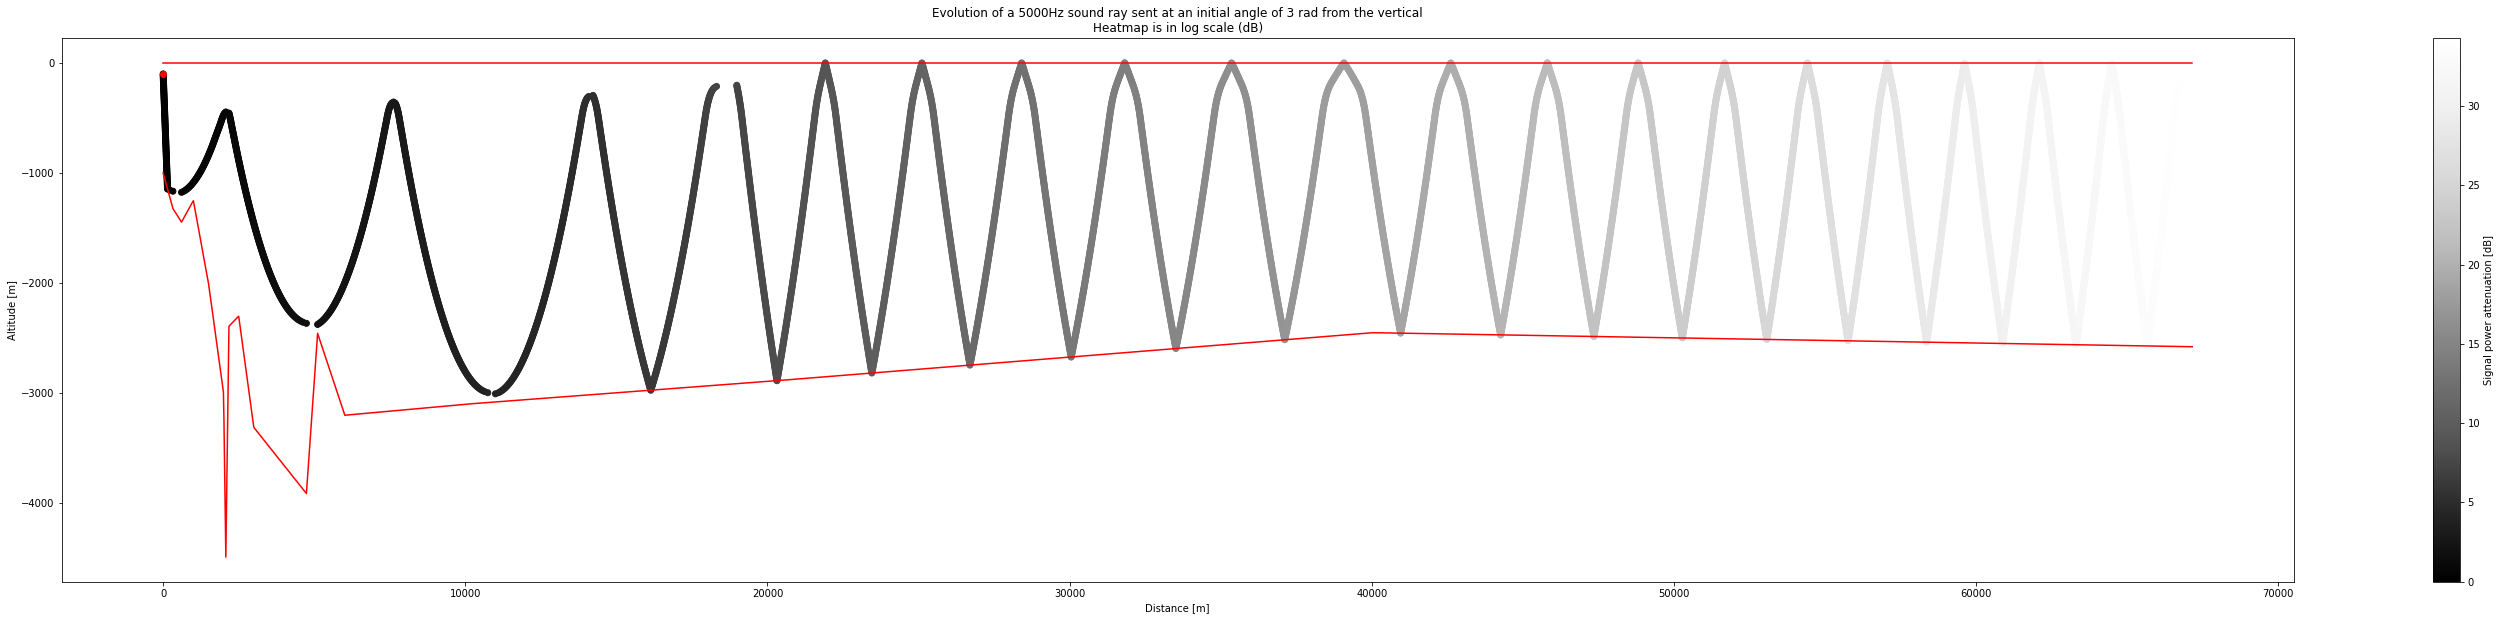

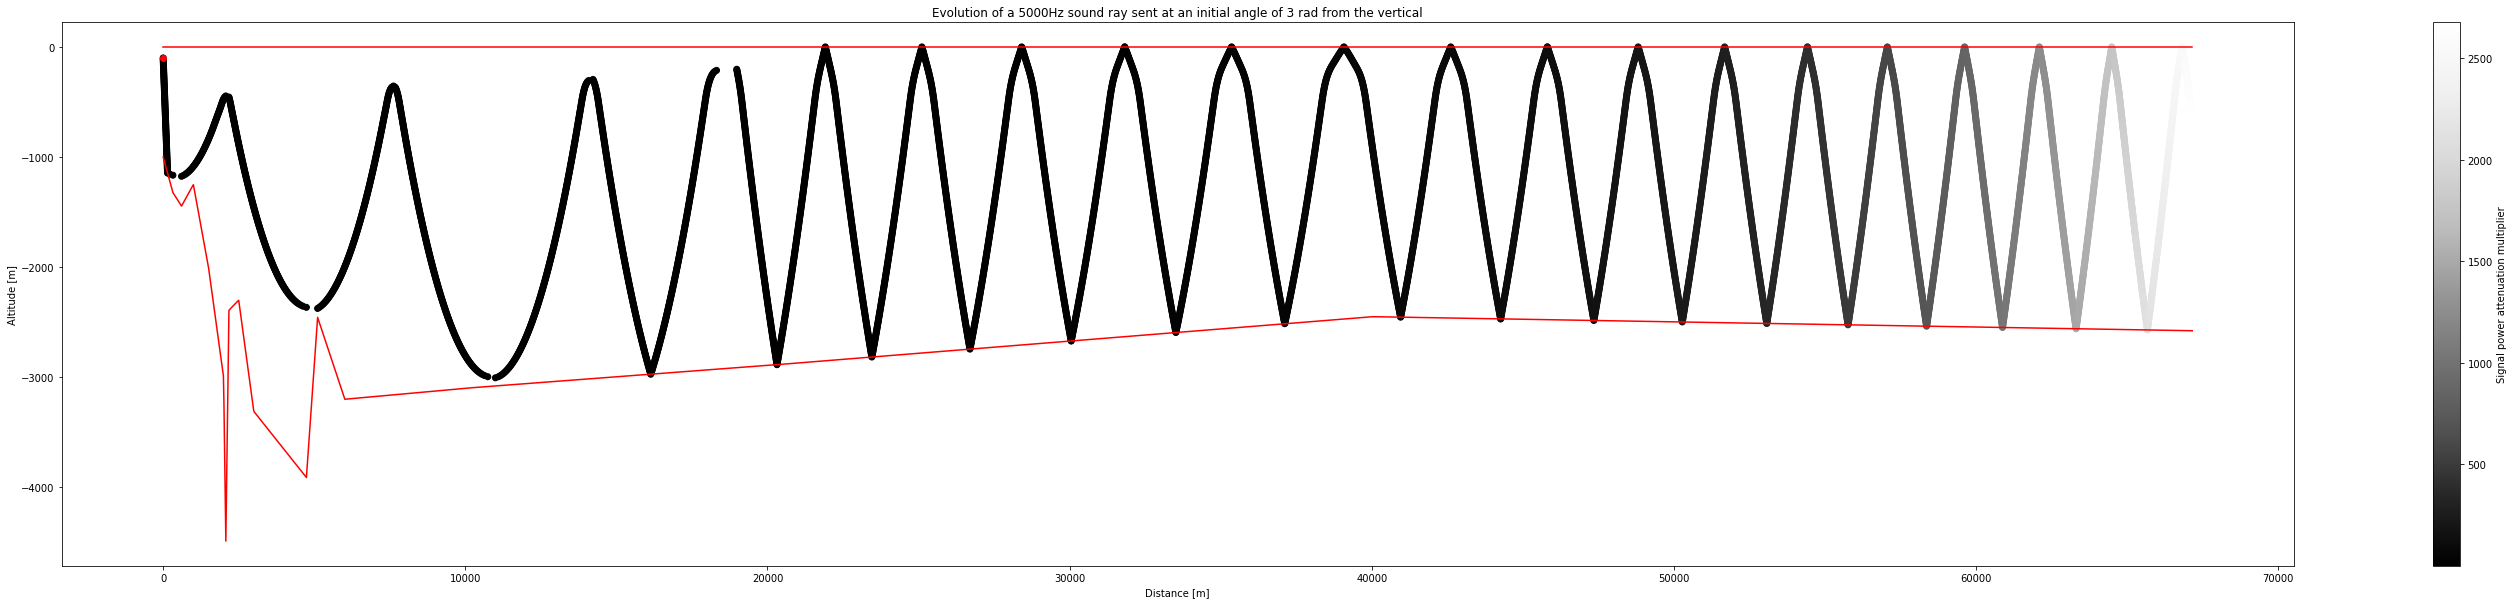

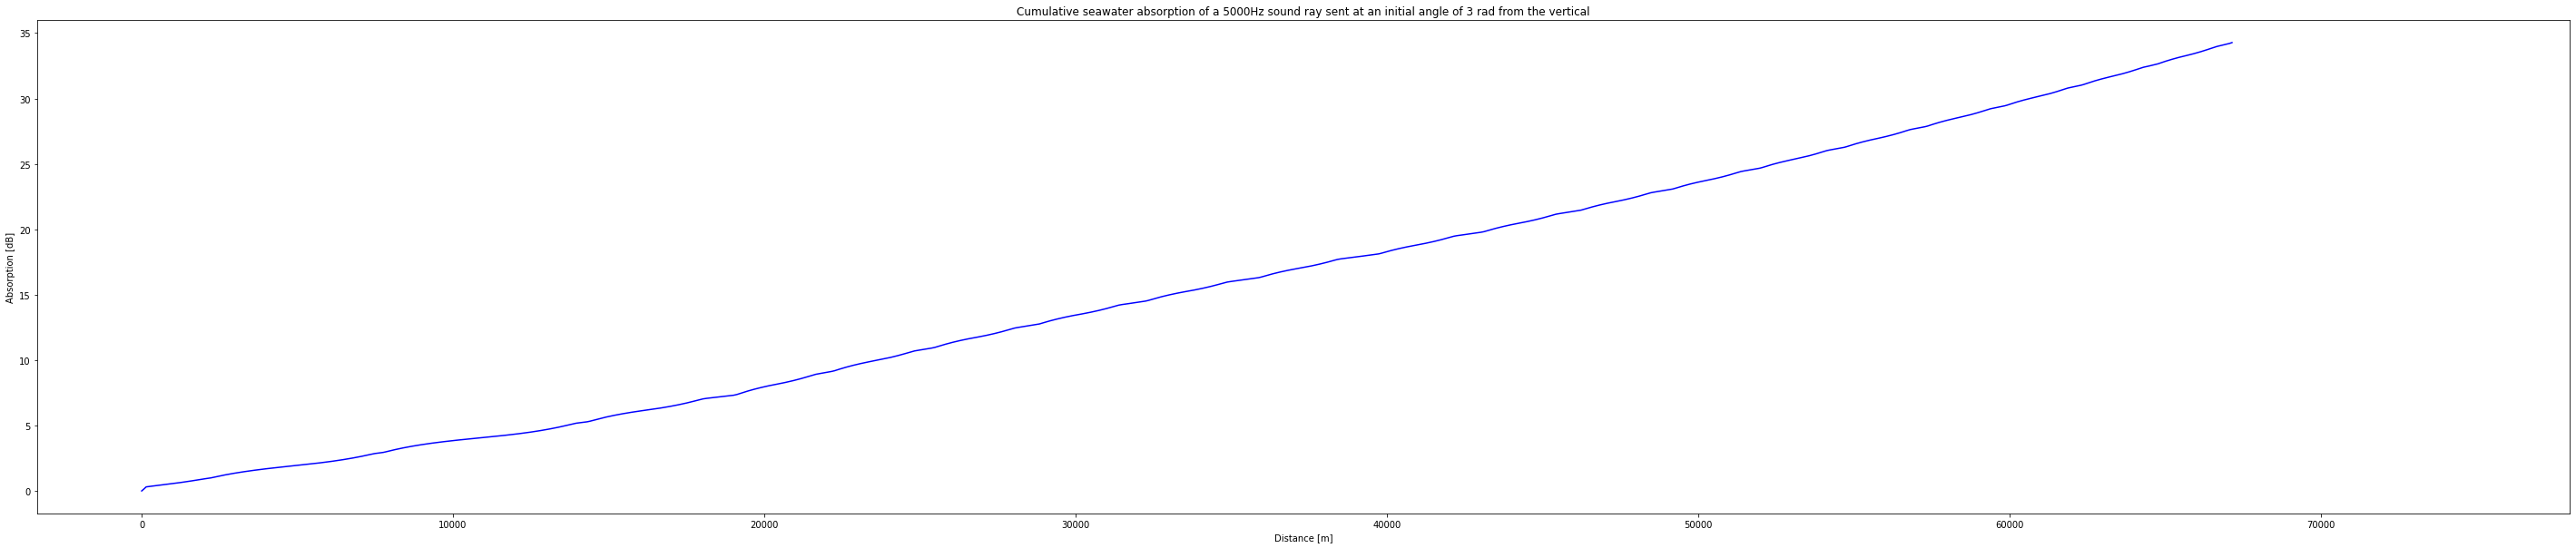

In [70]:
LIMIT_BOTTOM = calc_ground_z
n_steps = 10000
step_z = 10
x0 = 0
z0 = -100
theta_0 = 3
f = 5000  # Hz

X, Z, A = sound_curve_absorption(f, n_steps, step_z, x0, z0, theta_0, LIMIT_TOP, LIMIT_BOTTOM)


plt.figure(figsize=(50, 10))
# Plot sound ray
series = plt.scatter(X, Z, c=A, cmap='Greys_r')

# Plot keypoints and limits
plt.scatter(x0, z0, c='red')
plt.plot((X[0], X[-1]), (0, 0), c='red')
plt.plot(X, LIMIT_BOTTOM(X), c='red')

cbar = plt.colorbar(series)
cbar.ax.set_ylabel('Signal power attenuation [dB]')

plt.title(f'Evolution of a {f}Hz sound ray sent at an initial angle of {theta_0} rad from the vertical\nHeatmap is in log scale (dB)')
plt.xlabel('Distance [m]')
plt.ylabel('Altitude [m]')
plt.show()


##########


plt.figure(figsize=(50, 10))
# Plot sound ray
A_mult = np.power(10, A / 10)  # A/20 for ^1metric instead of power (^2metric)
series = plt.scatter(X, Z, c=A_mult, cmap='Greys_r')

# Plot keypoints and limits
plt.scatter(x0, z0, c='red')
plt.plot((X[0], X[-1]), (0, 0), c='red')
plt.plot(X, LIMIT_BOTTOM(X), c='red')

cbar = plt.colorbar(series)
cbar.ax.set_ylabel('Signal power attenuation inverse multiplier')


plt.title(f'Evolution of a {f}Hz sound ray sent at an initial angle of {theta_0} rad from the vertical')
plt.xlabel('Distance [m]')
plt.ylabel('Altitude [m]')
plt.show()


##########


plt.figure(figsize=(50, 10))
plt.plot(X, A, c='blue')
plt.title(f'Cumulative seawater absorption of a {f}Hz sound ray sent at an initial angle of {theta_0} rad from the vertical')
plt.xlim(right=78000)  # manual adjustment to match curves
plt.xlabel('Distance [m]')
plt.ylabel('Absorption [dB]')
plt.show()